In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Personal python module for masks and profiles (available on github)
import gilphot as gp 

In [2]:
# Loading in images
fitsfile_sub = "/home/cgilhuly/Workspace/Images/NGC4565_g_res_final.fits"
image_g_sub, header_g_sub = fits.getdata(fitsfile_sub, header=True)

fitsfile2_sub = "/home/cgilhuly/Workspace/Images/NGC4565_r_res_final.fits"
image_r_sub, header_r_sub = fits.getdata(fitsfile2_sub, header=True)

# Coordinates of image centre
center_sub = (502, 500) 

# Sky values and errors for each image quadrant
skyval_g_SE_sub = -0.842 # Based on greatest difference between adjacent radial bin
skyval_g_SE_err = 0.012  
skyval_g_SE_sys = 0.145 

skyval_g_NW_sub = -1.174 
skyval_g_NW_err = 0.027
skyval_g_NW_sys = 0.246

skyval_r_SE_sub = -0.932
skyval_r_SE_err =  0.013 
skyval_r_SE_sys = 0.152 

skyval_r_NW_sub = -1.433 
skyval_r_NW_err =  0.031
skyval_r_NW_sys = 0.588

# Image zeropoints (NOTE: no colour term included for g-band)
zerop_g = 27.299 
zerop_r = 27.032

pix_size = 2.5 # arcsec

# Loading source mask
mask_sub = fits.getdata("/home/cgilhuly/Workspace/Images/NGC4565_cutout_res_mask_v6.fits", header=False)

# Masking out already masked regions of each image (union, not intersection)
mask_sub[ image_g_sub == 0.00 ] = 1
mask_sub[ image_r_sub == 0.00 ] = 1

Will consider change in sky (within given quadrant) inside/outside designated sky annulus as an appropriate estimate of systematic uncertainty in sky measurements. 

# Calculating surface brightness and colour profiles

In [3]:
# Calculating NW profiles

rad_profile_g_sub, r_g_sub, err_g_sub = gp.radial_profile_slice(image_g_sub, mask_sub, center_sub, PA=136., width=5, bin_edges=[180,250,350,450], bin_widths=[3,5,10,50,100])
rad_profile_r_sub, r_r_sub, err_r_sub = gp.radial_profile_slice(image_r_sub, mask_sub, center_sub, PA=136., width=5, bin_edges=[180,250,350,450], bin_widths=[3,5,10,50,100])

mag_g_sub = zerop_g - 2.5*np.log10(np.array(rad_profile_g_sub) - skyval_g_NW_sub) + 5*np.log10(pix_size)
mag_r_sub = zerop_r - 2.5*np.log10(np.array(rad_profile_r_sub) - skyval_r_NW_sub) + 5*np.log10(pix_size)

# Upper and lower SB error limits (in mag/arcsec^2)
mag_g_p_sub, mag_g_m_sub = gp.calc_profile_error( rad_profile_g_sub, err_g_sub, skyval_g_NW_sub, skyval_g_NW_err, zerop_g )
mag_r_p_sub, mag_r_m_sub = gp.calc_profile_error( rad_profile_r_sub, err_r_sub, skyval_r_NW_sub, skyval_r_NW_err, zerop_r )

# Including systematic uncertainty in sky
mag_g_ps_sub, mag_g_ms_sub = gp.calc_profile_error( rad_profile_g_sub, err_g_sub, skyval_g_NW_sub, skyval_g_NW_err, zerop_g, skyval_g_NW_sys )
mag_r_ps_sub, mag_r_ms_sub = gp.calc_profile_error( rad_profile_r_sub, err_r_sub, skyval_r_NW_sub, skyval_r_NW_err, zerop_r, skyval_r_NW_sys )

# Colour and error (without and with sys. uncertainty in sky)
gmr_sub = np.array(mag_g_sub) - np.array(mag_r_sub)
gmr_err_sub = gp.calc_colour_error( rad_profile_g_sub, err_g_sub, rad_profile_r_sub, err_r_sub, skyval_g_NW_sub, skyval_r_NW_sub, skyval_g_NW_err, skyval_r_NW_err )
gmr_err_sub_sys = gp.calc_colour_error( rad_profile_g_sub, err_g_sub, rad_profile_r_sub, err_r_sub, skyval_g_NW_sub, skyval_r_NW_sub, skyval_g_NW_err, skyval_r_NW_err, skyval_g_NW_sys, skyval_r_NW_sys )

# Packaging up error bars for convenient plotting
g_err_NW = [mag_g_sub - mag_g_p_sub, mag_g_m_sub - mag_g_sub]
r_err_NW = [mag_r_sub - mag_r_p_sub, mag_r_m_sub - mag_r_sub]

gmr_p_NW = gmr_sub + gmr_err_sub_sys
gmr_m_NW = gmr_sub - gmr_err_sub_sys

/home/cgilhuly/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  
/home/cgilhuly/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/cgilhuly/Scripts/gilphot.py:201: RuntimeWarning: invalid value encountered in log10
  ) + 5*np.log10(pix_size)
/home/cgilhuly/Scripts/gilphot.py:205: RuntimeWarning: invalid value encountered in log10
  ) + 5*np.log10(pix_size)


In [4]:
# Calculating SE profiles

rad_profile_g_SE_sub, r_g_SE_sub, err_g_SE_sub = gp.radial_profile_slice(image_g_sub, mask_sub, center_sub, PA=316., width=5, bin_edges=[180,250,350,800], bin_widths=[3,5,10,50,100])
rad_profile_r_SE_sub, r_r_SE_sub, err_r_SE_sub = gp.radial_profile_slice(image_r_sub, mask_sub, center_sub, PA=316., width=5, bin_edges=[180,250,350,800], bin_widths=[3,5,10,50,100])

mag_g_SE_sub = zerop_g - 2.5*np.log10(np.array(rad_profile_g_SE_sub) - skyval_g_SE_sub) + 5*np.log10(pix_size)
mag_r_SE_sub = zerop_r - 2.5*np.log10(np.array(rad_profile_r_SE_sub) - skyval_r_SE_sub) + 5*np.log10(pix_size)

# Upper and lower SB error limits (in mag/arcsec^2)
mag_g_p_SE_sub, mag_g_m_SE_sub = gp.calc_profile_error( rad_profile_g_SE_sub, err_g_SE_sub, skyval_g_SE_sub, skyval_g_SE_err, zerop_g )
mag_r_p_SE_sub, mag_r_m_SE_sub = gp.calc_profile_error( rad_profile_r_SE_sub, err_r_SE_sub, skyval_r_SE_sub, skyval_r_SE_err, zerop_r )

# Including systematic uncertainty in sky
mag_g_ps_SE_sub, mag_g_ms_SE_sub = gp.calc_profile_error( rad_profile_g_SE_sub, err_g_SE_sub, skyval_g_SE_sub, skyval_g_SE_err, zerop_g, skyval_g_SE_sys )
mag_r_ps_SE_sub, mag_r_ms_SE_sub = gp.calc_profile_error( rad_profile_r_SE_sub, err_r_SE_sub, skyval_r_SE_sub, skyval_r_SE_err, zerop_r, skyval_r_SE_sys )

# Colour and error (without and with sys. uncertainty in sky)
gmr_SE_sub = np.array(mag_g_SE_sub) - np.array(mag_r_SE_sub)
gmr_err_SE_sub = gp.calc_colour_error( rad_profile_g_SE_sub, err_g_SE_sub, rad_profile_r_SE_sub, err_r_SE_sub, skyval_g_SE_sub, skyval_r_SE_sub, skyval_g_SE_err, skyval_r_SE_err )
gmr_err_SE_sub_sys = gp.calc_colour_error( rad_profile_g_SE_sub, err_g_SE_sub, rad_profile_r_SE_sub, err_r_SE_sub, skyval_g_SE_sub, skyval_r_SE_sub, skyval_g_SE_err, skyval_r_SE_err, skyval_g_SE_sys, skyval_r_SE_sys )

# Packaging up error bars for convenient plotting
g_err_SE = [mag_g_SE_sub - mag_g_p_SE_sub, mag_g_m_SE_sub - mag_g_SE_sub]
r_err_SE = [mag_r_SE_sub - mag_r_p_SE_sub, mag_r_m_SE_sub - mag_r_SE_sub]

gmr_p_SE = gmr_SE_sub + gmr_err_SE_sub_sys
gmr_m_SE = gmr_SE_sub - gmr_err_SE_sub_sys


/home/cgilhuly/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/cgilhuly/Scripts/gilphot.py:205: RuntimeWarning: invalid value encountered in log10
  ) + 5*np.log10(pix_size)


### Applying extinction corrections (very small due to Galactic cirrus-avoiding selection criteria)

In [5]:
# Galactic extinction (Schlafly et al. 2011; accessed via NED)
extinct_g = 0.051
extinct_r = 0.035

# NW
mag_g_sub = np.array(mag_g_sub) - extinct_g
mag_r_sub = np.array(mag_r_sub) - extinct_r

gmr_sub = np.array(gmr_sub) - extinct_g + extinct_r

mag_g_ps_sub = np.array(mag_g_ps_sub) - extinct_g
mag_g_ms_sub = np.array(mag_g_ms_sub) - extinct_g
mag_r_ps_sub = np.array(mag_r_ps_sub) - extinct_r
mag_r_ms_sub = np.array(mag_r_ms_sub) - extinct_r


# SE
mag_g_SE_sub = np.array(mag_g_SE_sub) - extinct_g
mag_r_SE_sub = np.array(mag_r_SE_sub) - extinct_r

gmr_SE_sub = np.array(gmr_SE_sub) - extinct_g + extinct_r

mag_g_ps_SE_sub = np.array(mag_g_ps_SE_sub) - extinct_g
mag_g_ms_SE_sub = np.array(mag_g_ms_SE_sub) - extinct_g
mag_r_ps_SE_sub = np.array(mag_r_ps_SE_sub) - extinct_r
mag_r_ms_SE_sub = np.array(mag_r_ms_SE_sub) - extinct_r


# NW gr profiles with g-r lower panel

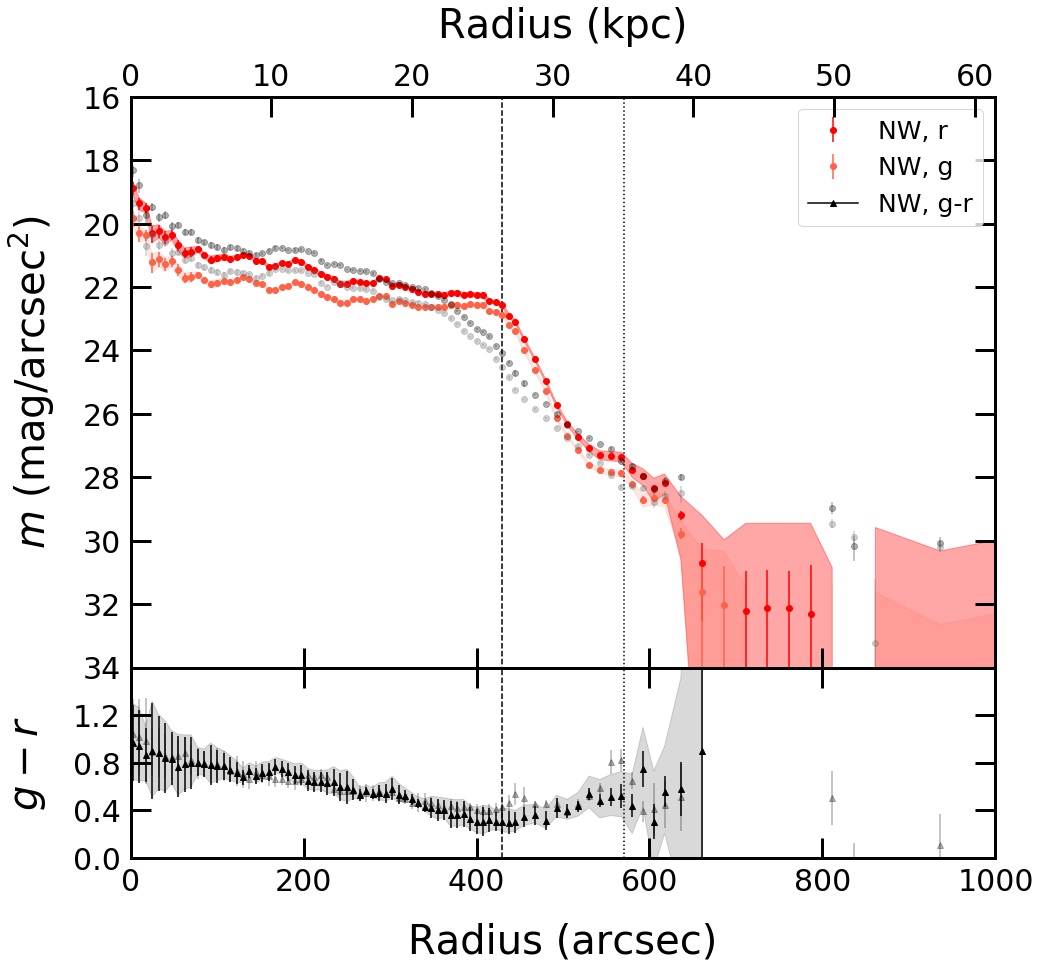

In [6]:
fig, ax0 = plt.subplots(ncols=1, nrows=2)
gs1 = gridspec.GridSpec(2,1,wspace=0,hspace=0, height_ratios = [3,1])

# Upper panel for plotting surface brightness profiles
ax = plt.subplot(gs1[0])

plt.errorbar( np.array(r_r_sub)*pix_size, mag_r_sub, yerr=r_err_NW, label="NW, r", fmt='o', color='red')
plt.errorbar( np.array(r_g_sub)*pix_size, mag_g_sub, yerr=g_err_NW, label="NW, g", fmt='o', color='tomato')

ax.errorbar([0], [0], label="NW, g-r", color='k', marker='^') # Dummy for legend in top panel

# Error envelopes including estimated systematic sky error
plt.fill_between(np.array(r_r_sub)*pix_size,mag_r_ps_sub, mag_r_ms_sub, alpha=0.35, color="red")
plt.fill_between(np.array(r_g_sub)*pix_size,mag_g_ps_sub, mag_g_ms_sub, alpha=0.15, color="tomato")

# Plotting SE profiles in faint grey for reference
plt.errorbar( np.array(r_r_SE_sub)*pix_size, mag_r_SE_sub, yerr=r_err_SE, color='black', fmt='o', alpha=0.3)
plt.errorbar( np.array(r_g_SE_sub)*pix_size, mag_g_SE_sub, yerr=g_err_SE, color='dimgrey', fmt='o', alpha=0.3)

leg = plt.legend(loc=1, prop={'size': 25})

# Setting label info
ax.set_ylabel(r"$m$ (mag/arcsec$^2$)", size=40, labelpad=25)
ax.tick_params(labelsize=30)
ax.set_xticklabels([]) 
ax.invert_yaxis()


# Lower panel for plotting colour profiles
ax2 = plt.subplot(gs1[1])

ax2.errorbar( np.array(r_r_sub)*pix_size, gmr_sub, yerr = gmr_err_sub, label="g-r", color='k', fmt='o', marker='^')
plt.fill_between(np.array(r_r_sub)*pix_size, gmr_m_NW, gmr_p_NW, alpha=0.15, color="k")

# Faint grey SE colour profile for reference
ax2.errorbar( np.array(r_r_SE_sub)*pix_size, gmr_SE_sub, yerr = gmr_err_SE_sub, color='black', fmt='o', marker='^', alpha=0.3)

# Setting label info
ax2.set_ylabel(r"$g-r$", size=40, labelpad=25)
ax2.set_xlabel(r"Radius (arcsec)", size=40, labelpad=25)
ax2.tick_params(labelsize=30)

# Tweaking weight of borders and ticks
ax.spines['bottom'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
ax2.spines['bottom'].set_linewidth(3)
ax2.spines['top'].set_linewidth(3)
ax2.spines['left'].set_linewidth(3)
ax2.spines['right'].set_linewidth(3)
    
ax.xaxis.set_tick_params(which='major',size=20,width=3,pad=10,top=True,right=True)
ax.yaxis.set_tick_params(which='major',size=20,width=3,pad=10,top=True,right=True)
ax.tick_params(axis='both',which='major',direction='in')
ax2.xaxis.set_tick_params(which='major',size=20,width=3,pad=10,top=True,right=True)
ax2.yaxis.set_tick_params(which='major',size=20,width=3,pad=10,top=True,right=True)
ax2.tick_params(axis='both',which='major',direction='in')


# Marking radii of interest: NW truncation radius and position of excess (fan)
ax.plot([430, 430],[12,35], 'k--')
ax.plot([570, 570],[12,35], 'k:')
ax2.plot([430, 430],[0,2], 'k--')
ax2.plot([570, 570],[0,2], 'k:')

# Secondary x axis for physical length scales
ax3 = ax.twiny()
ax3.set_xlim(0,61.48)  # 1000 arcsec at a distance of 12.7 Mpc
ax3.set_xlabel(r"Radius (kpc)", size=40, labelpad=25)
ax3.tick_params(labelsize=30)
ax3.xaxis.set_tick_params(which='major',size=20,width=3,pad=5,top=True,right=True, direction="in")
    
# Setting axis limits, forcing ticks for colour panel    
ax.set_xlim(0, 1000)
ax.set_ylim(34, 16)
ax2.set_xlim(0, 1000)
ax2.set_ylim(0, 1.6)
ax2.set_yticks([0,0.4, 0.8, 1.2, 1.6])
ax2.set_yticklabels(["0.0","0.4", "0.8", "1.2", ""])

# Saving profiles
#write_profile(r_r_sub, mag_r_sub, filename="/home/cgilhuly/Workspace/Profiles/NGC4565_NW_disc_slice_r_sub.txt")
#write_profile(r_g_sub, mag_g_sub, filename="/home/cgilhuly/Workspace/Profiles/NGC4565_NW_disc_slice_g_sub.txt")

fig.set_size_inches(15.5, 14)
plt.show()

# SE gr profiles with g-r lower panel

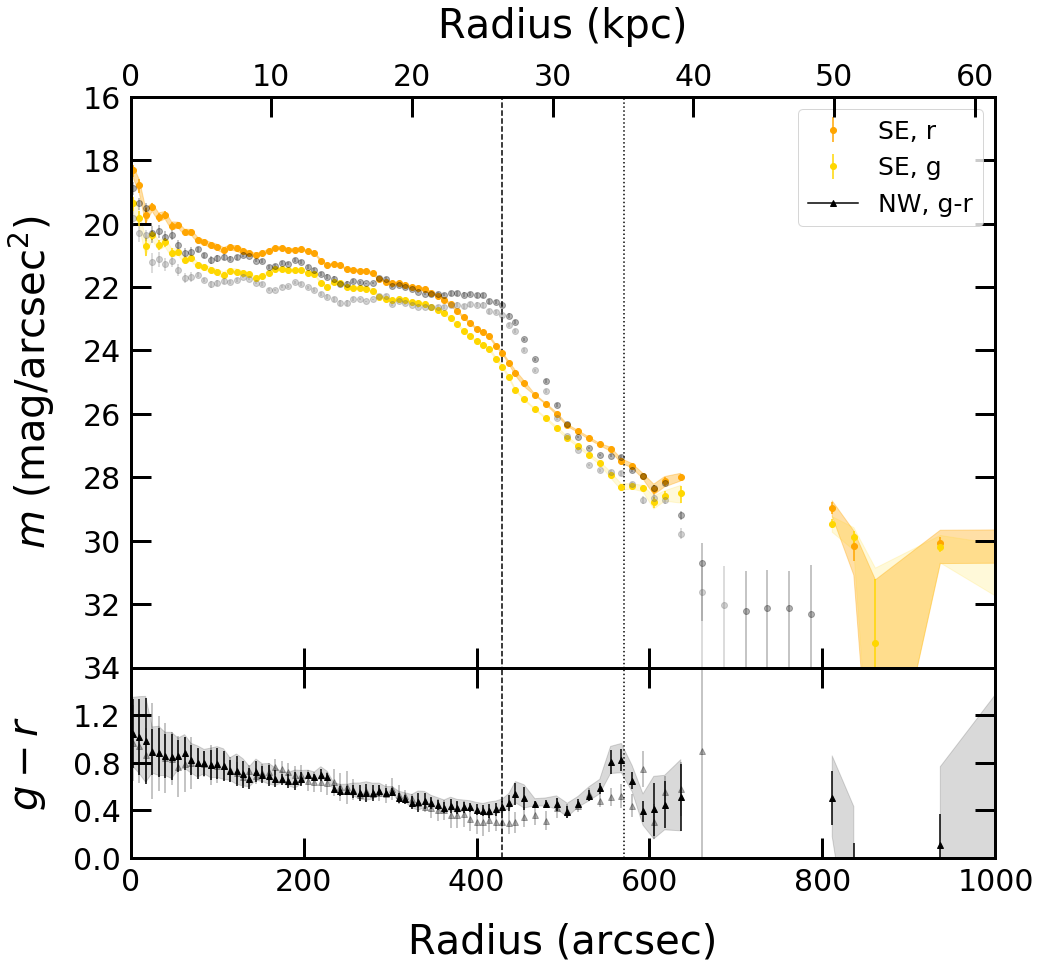

In [7]:
fig, ax0 = plt.subplots(ncols=1, nrows=2)
gs1 = gridspec.GridSpec(2,1,wspace=0,hspace=0, height_ratios = [3,1])

# Upper panel for plotting surface brightness profiles
ax = plt.subplot(gs1[0])

plt.errorbar( np.array(r_r_SE_sub)*pix_size, mag_r_SE_sub, yerr=r_err_SE, label="SE, r", fmt='o', color='orange')
plt.errorbar( np.array(r_g_SE_sub)*pix_size, mag_g_SE_sub, yerr=g_err_SE, label="SE, g", fmt='o', color='gold')

ax.errorbar([0], [0], label="NW, g-r", color='k', marker='^') # Dummy for legend in top panel

# Error envelopes including estimated systematic sky error
plt.fill_between(np.array(r_r_SE_sub)*pix_size,mag_r_ps_SE_sub, mag_r_ms_SE_sub, alpha=0.35, color="orange")
plt.fill_between(np.array(r_g_SE_sub)*pix_size,mag_g_ps_SE_sub, mag_g_ms_SE_sub, alpha=0.15, color="gold")

# Plotting NW profiles in faint grey for reference
plt.errorbar( np.array(r_r_sub)*pix_size, mag_r_sub, yerr=r_err_NW, color='black', fmt='o', alpha=0.3)
plt.errorbar( np.array(r_g_sub)*pix_size, mag_g_sub, yerr=g_err_NW, color='dimgrey', fmt='o', alpha=0.3)

leg = plt.legend(loc=1, prop={'size': 25})

# Setting label info
ax.set_ylabel(r"$m$ (mag/arcsec$^2$)", size=40, labelpad=25)
ax.tick_params(labelsize=30)
ax.set_xticklabels([]) 
ax.invert_yaxis()


# Lower panel for plotting colour profiles
ax2 = plt.subplot(gs1[1])

ax2.errorbar( np.array(r_r_SE_sub)*pix_size, gmr_SE_sub, yerr = gmr_err_SE_sub, label="g-r", color='k', fmt='o', marker='^')
plt.fill_between(np.array(r_r_SE_sub)*pix_size, gmr_m_SE, gmr_p_SE, alpha=0.15, color="k")

# Faint grey NW colour profile for reference
ax2.errorbar( np.array(r_r_sub)*pix_size, gmr_sub, yerr = gmr_err_sub, color='black', fmt='o', marker='^', alpha=0.3)

# Setting label info
ax2.set_ylabel(r"$g-r$", size=40, labelpad=25)
ax2.set_xlabel(r"Radius (arcsec)", size=40, labelpad=25)
ax2.tick_params(labelsize=30)

# Tweaking weight of borders and ticks
ax.spines['bottom'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
ax2.spines['bottom'].set_linewidth(3)
ax2.spines['top'].set_linewidth(3)
ax2.spines['left'].set_linewidth(3)
ax2.spines['right'].set_linewidth(3)
    
ax.xaxis.set_tick_params(which='major',size=20,width=3,pad=10,top=True,right=True)
ax.yaxis.set_tick_params(which='major',size=20,width=3,pad=10,top=True,right=True)
ax.tick_params(axis='both',which='major',direction='in')
ax2.xaxis.set_tick_params(which='major',size=20,width=3,pad=10,top=True,right=True)
ax2.yaxis.set_tick_params(which='major',size=20,width=3,pad=10,top=True,right=True)
ax2.tick_params(axis='both',which='major',direction='in')


# Marking radii of interest: NW truncation radius and position of excess (fan)
ax.plot([430, 430],[12,35], 'k--')
ax.plot([570, 570],[12,35], 'k:')
ax2.plot([430, 430],[0,2], 'k--')
ax2.plot([570, 570],[0,2], 'k:')

# Secondary x axis for physical length scales
ax3 = ax.twiny()
ax3.set_xlim(0,61.48)  # 1000 arcsec at a distance of 12.7 Mpc
ax3.set_xlabel(r"Radius (kpc)", size=40, labelpad=25)
ax3.tick_params(labelsize=30)
ax3.xaxis.set_tick_params(which='major',size=20,width=3,pad=5,top=True,right=True, direction="in")
    
# Setting axis limits, forcing ticks for colour panel    
ax.set_xlim(0, 1000)
ax.set_ylim(34, 16)
ax2.set_xlim(0, 1000)
ax2.set_ylim(0, 1.6)
ax2.set_yticks([0,0.4, 0.8, 1.2, 1.6])
ax2.set_yticklabels(["0.0","0.4", "0.8", "1.2", ""])

# Saving profiles
#write_profile(r_r_sub, mag_r_sub, filename="/home/cgilhuly/Workspace/Profiles/NGC4565_SE_disc_slice_r_sub.txt")
#write_profile(r_g_sub, mag_g_sub, filename="/home/cgilhuly/Workspace/Profiles/NGC4565_SE_disc_slice_g_sub.txt")

fig.set_size_inches(15.5, 14)
plt.show()

# Figure with SE and NW profiles "back to back"

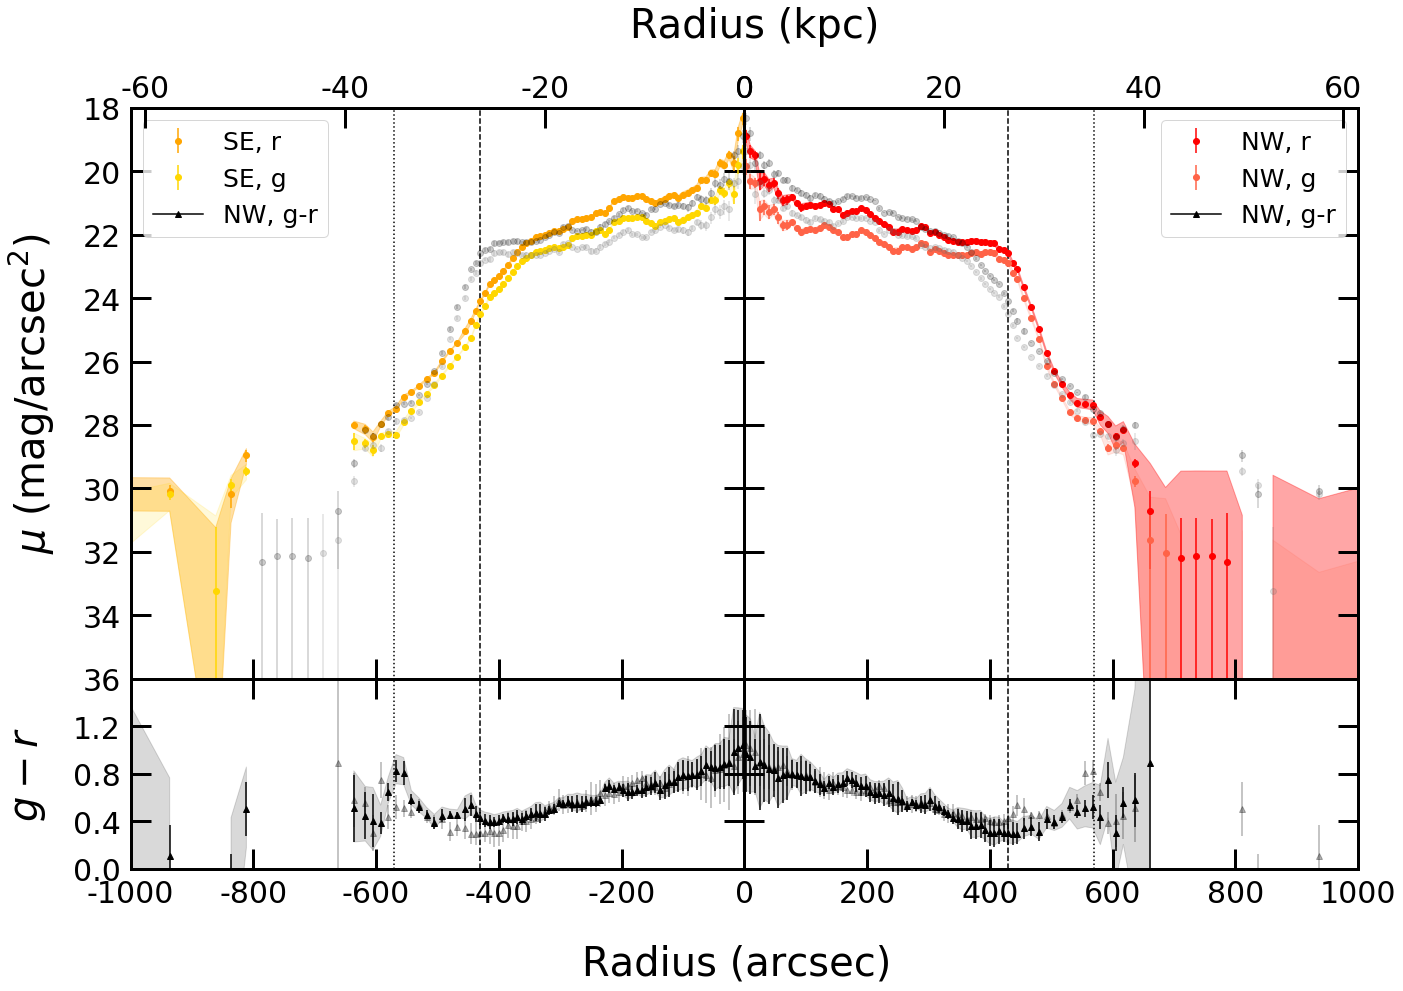

In [8]:
# Making figure with 4 subpanels
fig, ax = plt.subplots(ncols=2, nrows=2)
gs1 = gridspec.GridSpec(2,2,wspace=0,hspace=0, height_ratios = [3,1])

################################################################################
# SE surface brightness profiles (top left panel)
ax0 = plt.subplot(gs1[0])

plt.errorbar( np.array(r_r_SE_sub)*pix_size, mag_r_SE_sub, yerr=r_err_SE, label="SE, r", fmt='o', color='orange')
plt.errorbar( np.array(r_g_SE_sub)*pix_size, mag_g_SE_sub, yerr=g_err_SE, label="SE, g", fmt='o', color='gold')

ax0.errorbar([0], [0], label="NW, g-r", color='k', marker='^') # Dummy for legend

# Eror envelopes including systematic uncertainty in sky
plt.fill_between(np.array(r_r_SE_sub)*pix_size,mag_r_ps_SE_sub, mag_r_ms_SE_sub, alpha=0.35, color="orange")
plt.fill_between(np.array(r_g_SE_sub)*pix_size,mag_g_ps_SE_sub, mag_g_ms_SE_sub, alpha=0.15, color="gold")

# NW profiles in faint grey for reference
plt.errorbar( np.array(r_r_sub)*pix_size, mag_r_sub, yerr=r_err_NW, color='black', fmt='o', alpha=0.2)
plt.errorbar( np.array(r_g_sub)*pix_size, mag_g_sub, yerr=g_err_NW, color='dimgrey', fmt='o', alpha=0.2)

leg = plt.legend(loc=2, prop={'size': 25})  

ax0.set_xticklabels([])
ax0.set_ylabel(r"$\mu$ (mag/arcsec$^2$)", size=40, labelpad=25)
ax0.invert_yaxis()


################################################################################
# SE g-r profile (lower left panel)
ax2 = plt.subplot(gs1[2])

ax2.errorbar( np.array(r_r_SE_sub)*pix_size, gmr_SE_sub, yerr = gmr_err_SE_sub, label="g-r", color='k', fmt='o', marker='^')
plt.fill_between(np.array(r_r_SE_sub)*pix_size, gmr_m_SE, gmr_p_SE, alpha=0.15, color="k")

# NW profile in faint grey for reference
ax2.errorbar( np.array(r_r_sub)*pix_size, gmr_sub, yerr = gmr_err_sub, color='black', fmt='o', marker='^', alpha=0.3)

ax2.set_ylabel(r"$g-r$", size=40, labelpad=25)


################################################################################
# NW surface brightness profiles (top right panel)
ax1 = plt.subplot(gs1[1])

plt.errorbar( np.array(r_r_sub)*pix_size, mag_r_sub, yerr=r_err_NW, label="NW, r", fmt='o', color='red')
plt.errorbar( np.array(r_g_sub)*pix_size, mag_g_sub, yerr=g_err_NW, label="NW, g", fmt='o', color='tomato')

ax1.errorbar([0], [0], label="NW, g-r", color='k', marker='^') # Dummy for legend

# Error envelopes including systematic uncertainty in sky
plt.fill_between(np.array(r_r_sub)*pix_size,mag_r_ps_sub, mag_r_ms_sub, alpha=0.35, color="red")
plt.fill_between(np.array(r_g_sub)*pix_size,mag_g_ps_sub, mag_g_ms_sub, alpha=0.15, color="tomato")

# SE profiles in faint grey for reference
plt.errorbar( np.array(r_r_SE_sub)*pix_size, mag_r_SE_sub, yerr=r_err_SE, color='black', fmt='o', alpha=0.2)
plt.errorbar( np.array(r_g_SE_sub)*pix_size, mag_g_SE_sub, yerr=g_err_SE, color='dimgrey', fmt='o', alpha=0.2)

leg = plt.legend(loc=1, prop={'size': 25})
    
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.invert_yaxis()


################################################################################
# NW g-r profiles (bottom right panel)
ax3 = plt.subplot(gs1[3])

ax3.errorbar( np.array(r_r_sub)*pix_size, gmr_sub, yerr = gmr_err_sub, label="g-r", color='k', fmt='o', marker='^')
plt.fill_between(np.array(r_r_sub)*pix_size, gmr_m_NW, gmr_p_NW, alpha=0.15, color="k")

# SE profile in faint grey for reference
ax3.errorbar( np.array(r_r_SE_sub)*pix_size, gmr_SE_sub, yerr = gmr_err_SE_sub, color='black', fmt='o', marker='^', alpha=0.3)

ax3.set_yticklabels([])


################################################################################
# Common formatting for all subplots
for axis in [ax0, ax1, ax2, ax3]: 
    
    # Tick parameters
    axis.tick_params(axis='both',which='major',direction='in')
    axis.tick_params(labelsize=30)
    axis.yaxis.set_tick_params(which='major',size=20,width=3,pad=10,top=True,right=True)
    axis.xaxis.set_tick_params(which='major',size=20,width=3,pad=10,top=True,right=True)
     
    # Tweaking line weights
    axis.spines['bottom'].set_linewidth(3)
    axis.spines['top'].set_linewidth(3)
    axis.spines['left'].set_linewidth(3)
    axis.spines['right'].set_linewidth(3)
    
    # Adding lines for NW truncation radius and fan radius
    axis.plot([430, 430],[0,36], 'k--')
    axis.plot([570, 570],[0,36], 'k:')
    
# Secondary x axis for physical length scales (SE side)
ax02 = ax0.twiny()
ax02.set_xlim(61.48,0)  # 1000 arcsec at a distance of 12.7 Mpc
ax02.tick_params(labelsize=30)
ax02.xaxis.set_tick_params(which='major',size=20,width=3,pad=5,top=True,right=True, direction="in")

# Secondary x axis (NW side)
ax12 = ax1.twiny()
ax12.set_xlim(0,61.48)  # 1000 arcsec at a distance of 12.7 Mpc
ax12.tick_params(labelsize=30)
ax12.xaxis.set_tick_params(which='major',size=20,width=3,pad=5,top=True,right=True, direction="in")

# Fixing plot limits
ax1.set_xlim(0, 1000)
ax1.set_ylim(36, 18)
ax3.set_xlim(0, 1000)
ax3.set_ylim(0, 1.6)
ax3.set_yticks([0,0.4, 0.8, 1.2, 1.6])

ax0.set_xlim(1000,0)
ax0.set_ylim(36, 18)
ax2.set_xlim(1000, 0)
ax2.set_ylim(0, 1.6)
ax2.set_yticks([0,0.4, 0.8, 1.2, 1.6])
ax2.set_yticklabels(["0.0","0.4", "0.8", "1.2", ""])

# Using negative radius labels for reversed SE side of figure
ax2.set_xticklabels(["", "-200", "-400", "-600", "-800", "-1000"])
ax02.set_xticklabels(["0", "-20", "-40", "-60"])

# Shared axis labels
fig.text(0.41, 0.02, "Radius (arcsec)", size=40)
fig.text(0.44, 0.95, "Radius (kpc)", size=40)

fig.set_size_inches(22, 14)
plt.show()

### Comparison with Wu et al. (2002) 660 nm profiles (~i band)

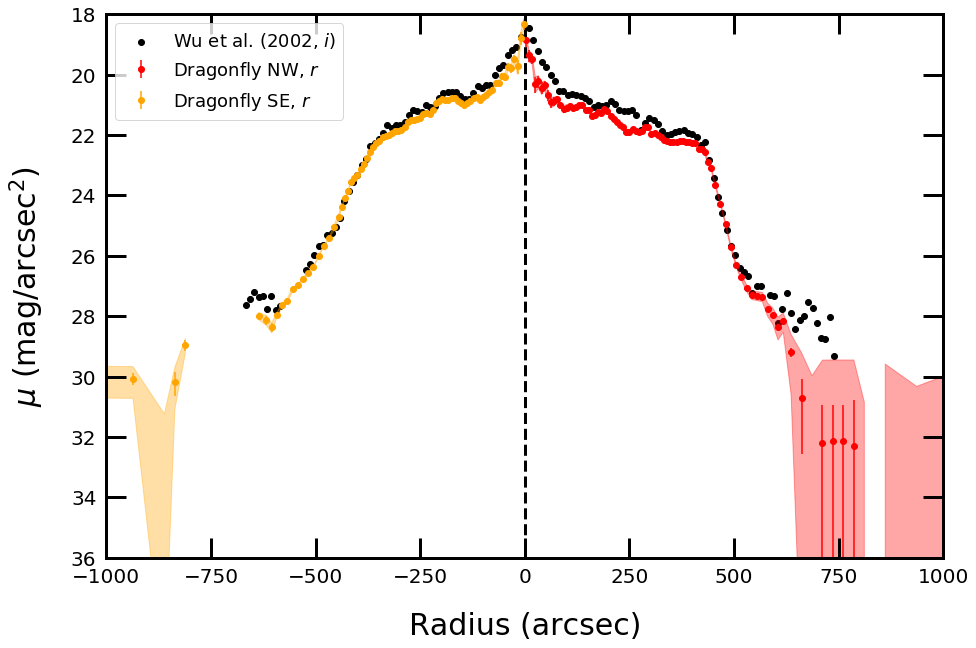

In [9]:
# Profile in NGC4565_wu02_i.prof in ~/Workspace/Profiles
# Relevant columns: 1 (radius in arcsec), 3 (SB in mag/arcsec^2)

wu_data = open("/home/cgilhuly/Workspace/Profiles/NGC4565_wu02_i.prof", "r")
SB_wu = []
rad_wu = []

for line in wu_data:
    
    if line.startswith( "#" ):
        continue
        
    SB_wu.append( float( line.split()[3] ) )
    rad_wu.append( float( line.split()[1] ) )
    
wu_data.close()

fig, ax = plt.subplots()

plt.scatter( rad_wu, SB_wu, c='k', label="Wu et al. (2002, $i$)" )
plt.errorbar( np.array(r_r_sub)*pix_size, mag_r_sub, yerr=r_err_NW, label="Dragonfly NW, $r$", fmt='o', color='red')
plt.errorbar( np.array(r_r_SE_sub)*pix_size*-1., mag_r_SE_sub, yerr=r_err_SE, label="Dragonfly SE, $r$", fmt='o', color='orange')

plt.fill_between(np.array(r_r_sub)*pix_size,mag_r_ps_sub, mag_r_ms_sub, alpha=0.35, color="red")
plt.fill_between(np.array(r_r_SE_sub)*pix_size*-1.,mag_r_ps_SE_sub, mag_r_ms_SE_sub, alpha=0.35, color="orange")

ax.set_ylabel(r"$\mu$ (mag/arcsec$^2$)", size=30, labelpad=25)
ax.set_xlabel(r"Radius (arcsec)", size=30, labelpad=25)

leg = plt.legend(loc=2, prop={'size': 18})

# Tweaking appearance of plot
ax.spines['bottom'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)

ax.tick_params(labelsize=20)
ax.xaxis.set_tick_params(which='major',size=20,width=3,pad=10,top=True,right=True)
ax.yaxis.set_tick_params(which='major',size=20,width=3,pad=10,top=True,right=True)
ax.tick_params(axis='both',which='major',direction='in')

ax.set_xlim(-1000,1000)
ax.set_ylim(36, 18)

# Plotting vertical line at galaxy centre (r = 0)
ax.plot([0, 0],[0,36], 'k--', lw=3)

fig.set_size_inches(15, 10)

plt.show()